In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    # !mkdir -p images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: False
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-o4fe2ayf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-o4fe2ayf
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cach

In [3]:
import sys
!{sys.executable} -m pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [4]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [5]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cpu


In [7]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [8]:
!mkdir -p frames/demo/

In [ ]:
!find frames/demo -name "*.zip" | while read file; do \
  unzip "$file" -d "$(dirname "$file")"; \
  rm "$file"; \
  find "$(dirname "$file")" -name "*.zip" | while read inner_zip; do \
    unzip "$inner_zip" -d "$(dirname "$inner_zip")"; \
    rm "$inner_zip"; \
  done; \
done

In [10]:
print(os.listdir())

['.config', 'hand_landmarker.task', 'frames', 'sample_data']


In [11]:
def frame(video_dir):
    # scan all the JPEG frame names in this directory
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    # take a look the first video frame
    frame_idx = 0
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {frame_names[frame_idx]}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

    return frame_names

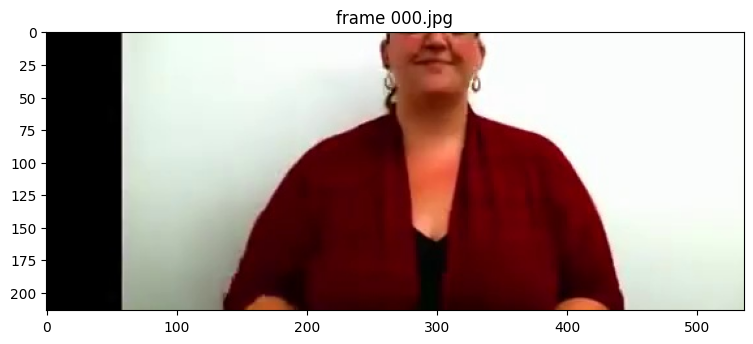

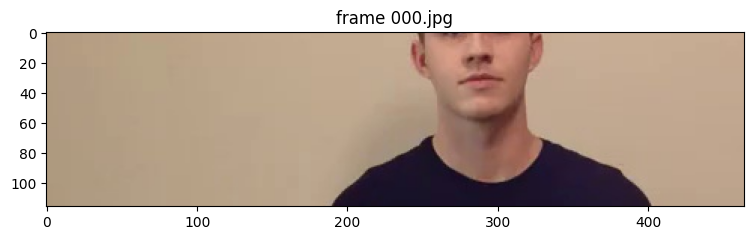

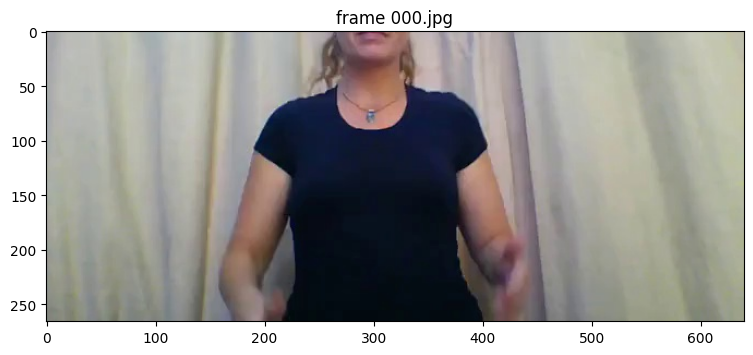

In [12]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir1 = "./frames/demo/video1"
video_dir5 = "./frames/demo/video5"
video_dir9 = "./frames/demo/video9"

frame_names1 = frame(video_dir1)
frame_names5 = frame(video_dir5)
frame_names9 = frame(video_dir9)

## Mediapipe

In [13]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [14]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
# from google.colab.patches import cv2_imshow

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

In [24]:
from pickle import FALSE

def mediapipe(video_dir, frame_names):
    # STEP 3: Load the input image.
    folder_path = video_dir

    for filename in frame_names:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            media_image = mp.Image.create_from_file(image_path)

            # STEP 4: Detect hand landmarks from the input image.
            detection_result = detector.detect(media_image)
            if detection_result.handedness == []:
                continue

            else:
                # STEP 5: Process the classification result. In this case, visualize it.
                annotated_image = draw_landmarks_on_image(media_image.numpy_view(), detection_result)

                plt.figure(figsize=(9, 6))
                plt.title(f"frame {filename}")
                plt.imshow(annotated_image)
                plt.show()
                break
    return filename, detection_result

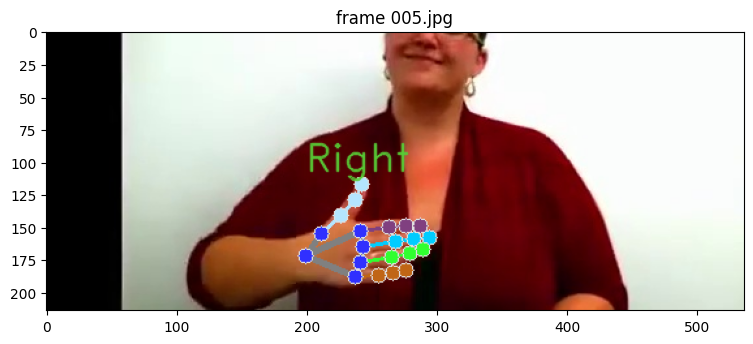

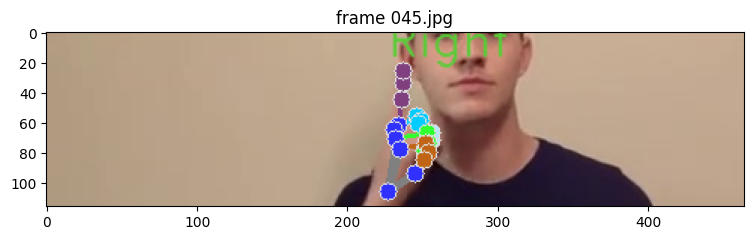

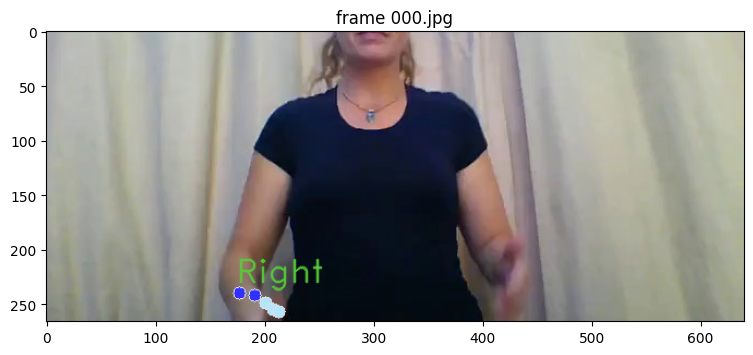

In [26]:
filename1, detection_result1 = mediapipe(video_dir1, frame_names1)
filename5, detection_result5 = mediapipe(video_dir5, frame_names5)
filename9_1, detection_result9_1 = mediapipe(video_dir9, frame_names9)

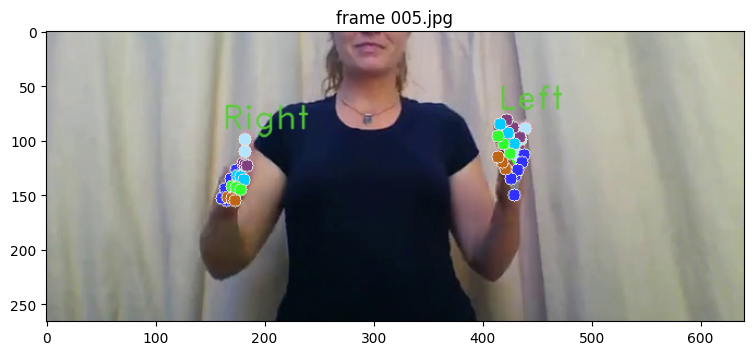

In [27]:
# TESTING BOTH HANDS
filename9_2 = "005.jpg"
image_path = os.path.join(video_dir9, filename9_2)
media_image = mp.Image.create_from_file(image_path)
detection_result9_2 = detector.detect(media_image)
annotated_image = draw_landmarks_on_image(media_image.numpy_view(), detection_result9_2)

plt.figure(figsize=(9, 6))
plt.title(f"frame {filename9_2}")
plt.imshow(annotated_image)
plt.show()

In [52]:
def print_info(video_dir, filename, detection_result):
    print(f"First frame name: {video_dir}/{filename}")
    index = int(os.path.splitext(filename)[0]) // 5
    print(f"First frame index: {index}")
    print(f"Numbers of detections: {len(detection_result.handedness)}")
    print(detection_result.handedness)
    print("\n")
    return index


In [53]:
index1 = print_info(video_dir1, filename1, detection_result1)
index5 = print_info(video_dir5, filename5, detection_result5)
index9_1 = print_info(video_dir9, filename9_1, detection_result9_1)
index9_2 = print_info(video_dir9, filename9_2, detection_result9_2)

First frame name: ./frames/demo/video1/005.jpg
First frame index: 1
Numbers of detections: 1
[[Category(index=0, score=0.9703763127326965, display_name='Right', category_name='Right')]]


First frame name: ./frames/demo/video5/045.jpg
First frame index: 9
Numbers of detections: 1
[[Category(index=0, score=0.9967215061187744, display_name='Right', category_name='Right')]]


First frame name: ./frames/demo/video9/000.jpg
First frame index: 0
Numbers of detections: 1
[[Category(index=0, score=0.8632116913795471, display_name='Right', category_name='Right')]]


First frame name: ./frames/demo/video9/005.jpg
First frame index: 1
Numbers of detections: 2
[[Category(index=0, score=0.8347914218902588, display_name='Right', category_name='Right')], [Category(index=1, score=0.989032506942749, display_name='Left', category_name='Left')]]




### Plot region bounding

In [36]:
def convert_coords(folder_path, filename, detection_result):
    image_path = os.path.join(folder_path, filename)
    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))

    height, width, _ = image.shape
    # Convert relative coords to pixel coords
    pixel_points = np.array([
        [lm.x * width,lm.y * height]  # if coords are centered around 0
        for sublist in detection_result.hand_landmarks
        for lm in sublist
    ])
    return image, pixel_points

In [37]:
image1, pixel_points1 = convert_coords(video_dir1, filename1, detection_result1)
image5, pixel_points5 = convert_coords(video_dir5, filename5, detection_result5)
image9_1, pixel_points9_1 = convert_coords(video_dir9, filename9_1, detection_result9_1)
image9_2, pixel_points9_2 = convert_coords(video_dir9, filename9_2, detection_result9_2)

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_bb(image, pixel_points, detection_result):
    num_objects = len(detection_result.handedness)
    landmarks_per_object = pixel_points.shape[0] // num_objects
    assert pixel_points.shape[0] % num_objects == 0, "Inconsistent shape with num_objects"

    boxes = []

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    ax.set_title("Bounding Boxes Around Landmarks")
    ax.axis('off')

    for i in range(num_objects):
        start = i * landmarks_per_object
        end = (i + 1) * landmarks_per_object
        points = pixel_points[start:end]  # shape: (landmarks_per_object, 2)

        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)
        boxes.append((x_min, y_min, x_max, y_max))

        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height,
                                linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    plt.show()
    return boxes

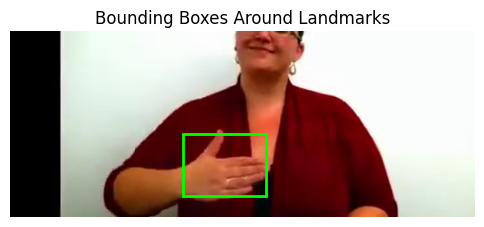

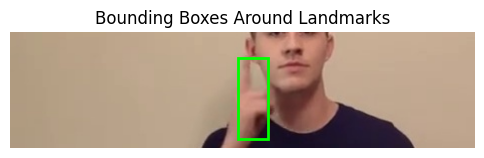

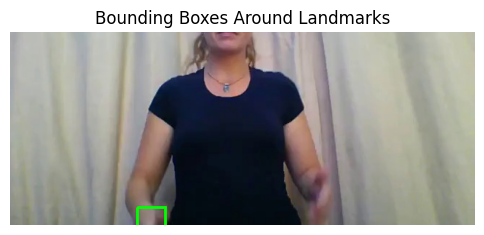

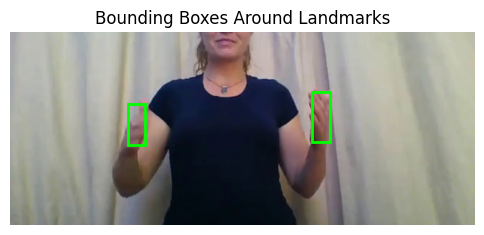

In [42]:
boxes1 = plot_bb(image1, pixel_points1, detection_result1)
boxes5 = plot_bb(image5, pixel_points5, detection_result5)
boxes9_1 = plot_bb(image9_1, pixel_points9_1, detection_result9_1)
boxes9_2 = plot_bb(image9_2, pixel_points9_2, detection_result9_2)

## Automatic mask generation

In [40]:
from sam2.build_sam import build_sam2
from sam2.build_sam import build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

## Initialize the inference state
SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video.

During initialization, it loads all the JPEG frames in video_path and stores their pixels in inference_state (as shown in the progress bar below).

In [58]:
inference_state1 = predictor.init_state(video_path=video_dir1)
inference_state5 = predictor.init_state(video_path=video_dir5)
inference_state9_1 = predictor.init_state(video_path=video_dir9)
inference_state9_2 = predictor.init_state(video_path=video_dir9)

frame loading (JPEG): 100%|██████████| 25/25 [00:00<00:00, 26.94it/s]


In [44]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Single Object

In [48]:
def single_object(index, inference_state, boxes, video_dir, frame_names):
    ann_frame_idx = index  # the frame index we interact with
    ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        box=boxes[0],
    )

    # show the results on the current (interacted) frame
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_box(boxes[0], plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

# Multiple Objects

In [59]:
def mult_object(index, inference_state_n, boxes, video_dir, frame_names):
    ann_frame_idx = index  # the frame index we interact with
    ann_obj_id = [0, 1]

    # FIRST OBJECT
    ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state_n,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            box=boxes[0],
        )

    # SECOND OBJECT
    ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state_n,
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                box=boxes[1],
            )

    # show the results on the current (interacted) frame on all objects
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    for i, out_obj_id in enumerate(out_obj_ids):
        # show_points(*prompts[out_obj_id], plt.gca())
        show_box(boxes[i], plt.gca())
        show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [60]:
def video_propagation(index, inference_state_n, video_dir, frame_names):
    ann_frame_idx = index
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state_n):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    # render the segmentation results every few frames
    vis_frame_stride = 5
    plt.close("all")
    for out_frame_idx in range(ann_frame_idx, len(frame_names), vis_frame_stride):
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {frame_names[out_frame_idx]}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    # output: video_segments
    return video_segments

# Segmentation Results

## 1. Correctly detecting single hand

/usr/local/lib/python3.11/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.11/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


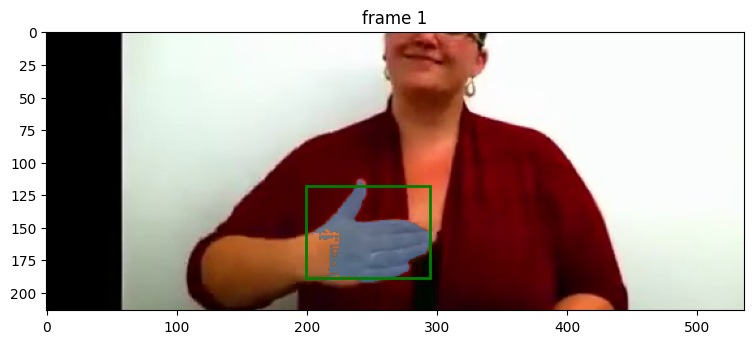

In [61]:
single_object(index1, inference_state1, boxes1, video_dir1, frame_names1)

propagate in video: 100%|██████████| 14/14 [12:24<00:00, 53.18s/it]


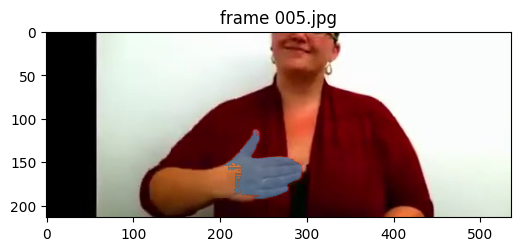

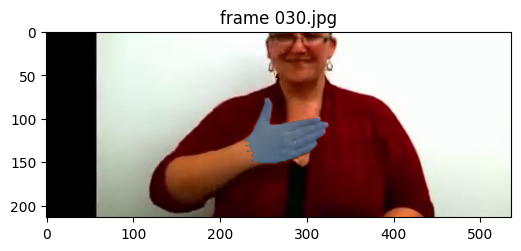

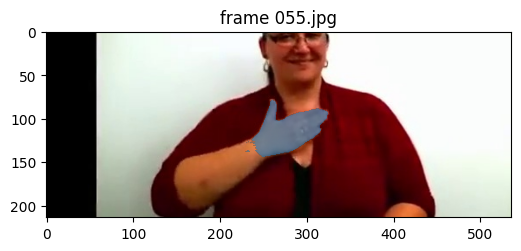

In [62]:
video_segments1 = video_propagation(index1, inference_state1, video_dir1, frame_names1)

## 2. Correctly detecting two hands

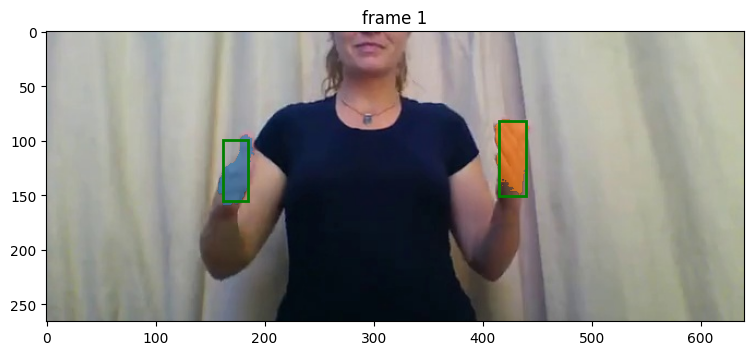

In [63]:
mult_object(index9_2, inference_state9_1, boxes9_2, video_dir9, frame_names9)

propagate in video: 100%|██████████| 24/24 [27:06<00:00, 67.76s/it]


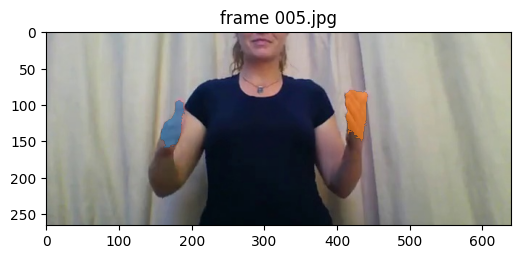

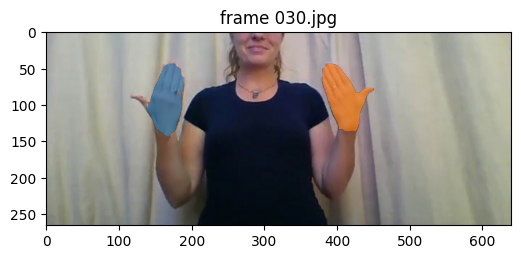

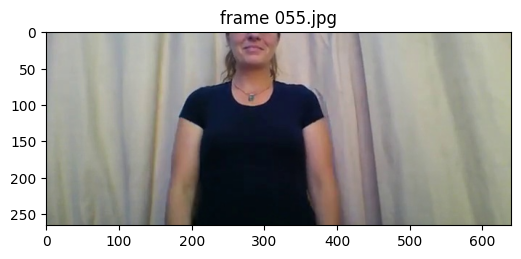

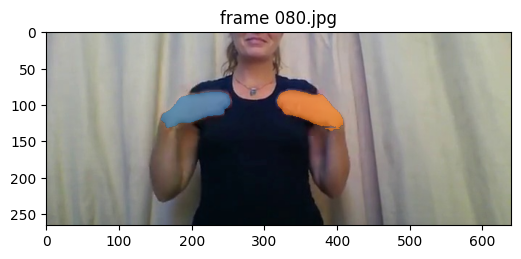

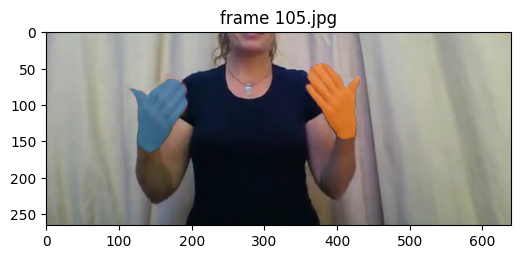

In [64]:
video_segments9_2 = video_propagation(index9_2, inference_state9_1, video_dir9, frame_names9)

## 3. Erroneous single hand

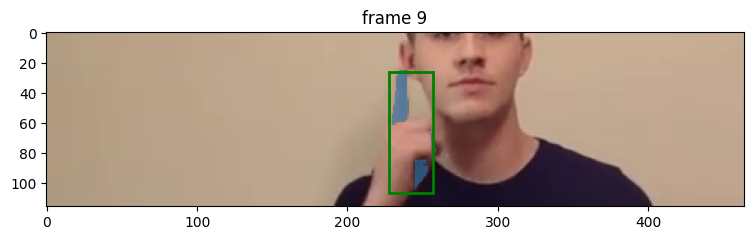

In [65]:
single_object(index5, inference_state5, boxes5, video_dir5, frame_names5)

propagate in video: 100%|██████████| 13/13 [11:08<00:00, 51.42s/it]


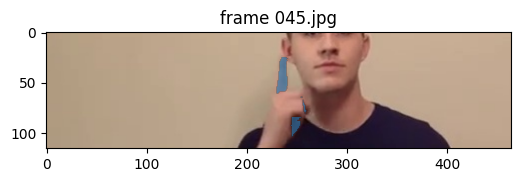

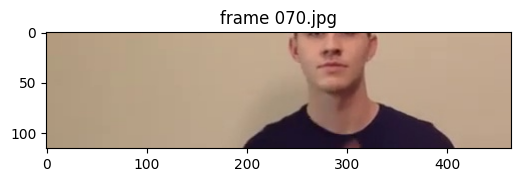

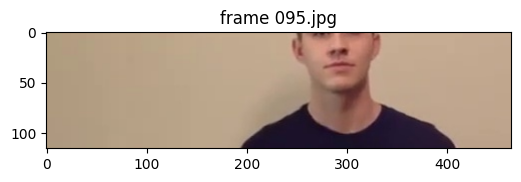

In [66]:
video_segments5 = video_propagation(index5, inference_state5, video_dir5, frame_names5)

## 4. Erroneous two hands

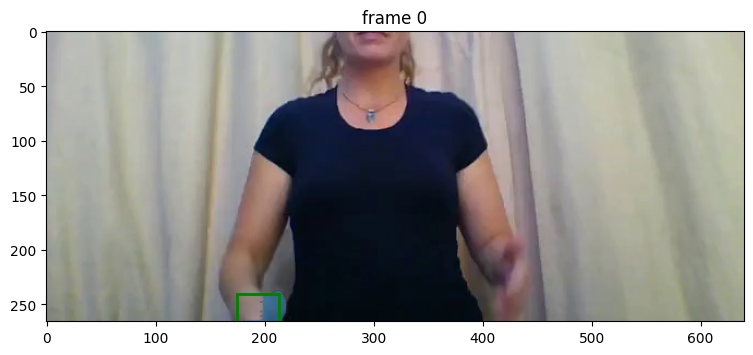

In [67]:
if len(detection_result9_1.handedness) == 1:
    single_object(index9_1, inference_state9_2, boxes9_1, video_dir9, frame_names9)
else:
    mult_object(index9_2, inference_state9_2, boxes9_2, video_dir9, frame_names9)

propagate in video: 100%|██████████| 25/25 [22:55<00:00, 55.03s/it]


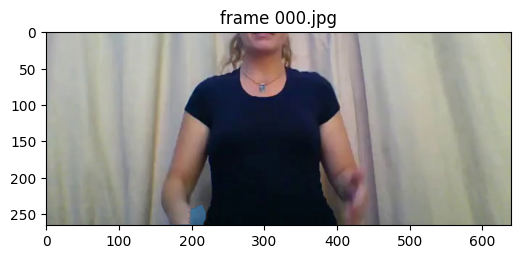

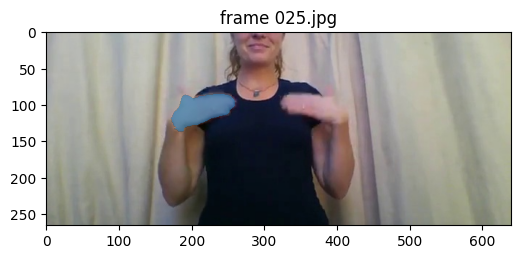

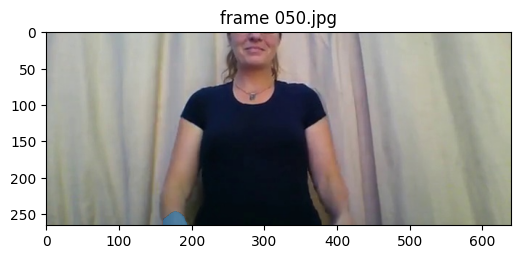

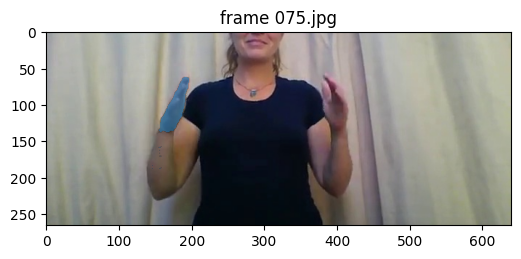

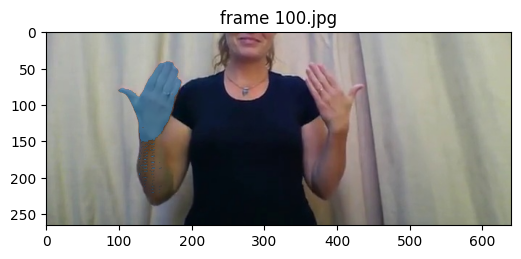

In [68]:
video_segments9_1 = video_propagation(index9_1, inference_state9_2, video_dir9, frame_names9)